In [24]:
import json
import csv
import numpy as np
import math
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import plotly.io as pio
import os
import re
from time import sleep
from matplotlib.animation import FuncAnimation
from scipy.signal import find_peaks
from scipy.optimize import curve_fit

In [28]:
path=r"Runs\031123\Pi2/"

# Load Parameters & Data

In [29]:
def save_param(csv_file_path=path+"params.csv"):
    # Open the CSV file
    with open(csv_file_path, mode='r') as infile:
        reader = csv.reader(infile)
        mydict = {rows[0]:rows[1] for rows in reader}
    return mydict

variable_dict=save_param()

box_size=float(variable_dict["boxSize"])
r=float(variable_dict["sigma"])/2.0
dataCompression=int(variable_dict["dataCompression"])
numSteps=int(variable_dict["numSteps"])
timestep=float(variable_dict["timestep"])
numParticles=int(variable_dict["numParticles"])
theta=(variable_dict["theta"])

with open(path+'particle_positions.json', 'r') as file:
    data = json.load(file)

# Convert the data to a NumPy array
particle_positions = np.array(data)

# Plot Energy

In [30]:
def energy_plotly_plotter(xlabel, ylabel, legend_names, colors):
    time = []
    kinetic_energy = []
    potential_energy = []
    total_energy = []

    for t in range(len(particle_positions)):
        time.append(float(t)*dataCompression*timestep)
        kinetic_energy_total=0.0
        i=0
        for _, _ ,vx ,vy , _, PE in particle_positions[t]:
            kinetic_energy_total+=(float(0.5 * (vx**2 + vy**2)))
            if i==len(particle_positions[0])-1:
                potential_energy_per_particle=float(PE)
                kinetic_energy_per_particle=kinetic_energy_total/float(len(particle_positions[0]))
            i+=1
        potential_energy.append(potential_energy_per_particle)
        kinetic_energy.append(kinetic_energy_per_particle)
        total_energy.append(potential_energy_per_particle+kinetic_energy_per_particle)
    # Create Plotly figure
    fig = go.Figure()

    fig.add_trace(go.Scatter(x=time, y=kinetic_energy, mode='lines', name=legend_names[0], line=dict(color=colors[0])))
    fig.add_trace(go.Scatter(x=time, y=potential_energy, mode='lines', name=legend_names[1], line=dict(color=colors[1])))
    fig.add_trace(go.Scatter(x=time, y=total_energy, mode='lines', name=legend_names[2], line=dict(color=colors[2])))

    fig.update_layout(title="Energy Plot", xaxis_title=xlabel, yaxis_title=ylabel, width=1200, height=600)

    pio.write_html(fig, path+'tempi.html')
    fig.show()
legend_names = ["Kinetic Energy", "Potential Energy", "Total Energy"]
colors = ['blue', 'green', 'red']
energy_plotly_plotter("Time", "Energy per Particle", legend_names, colors)

In [ ]:
# Save the plot as PNG
# f=0
# legend_names = ["Kinetic Energy", "Potential Energy", "Total Energy"]
# colors = ['blue', 'green', 'red']
# while True:
#         energy_plotly_plotter("Time", "Energy per Particle", legend_names, colors)
#         if f<1:
#             os.system(f"start {os.getcwd()}/tempi.html")
#         f+=1
        sleep(10) #change to increase delay

# Final Frame Plotter

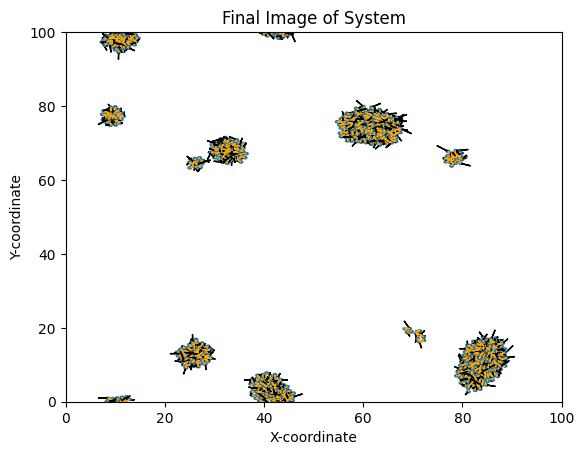

<Figure size 640x480 with 0 Axes>

In [31]:
def FinalSysImagePlotter():
    # Create a figure and axis for the Plot
    fig, ax = plt.subplots()
    ax.set_xlim(0, box_size)
    ax.set_ylim(0, box_size)
    
    for x, y ,vx ,vy , phi, PE in particle_positions[-1]:
        circle = plt.Circle((x, y), radius=r, linewidth=0)
        ax.add_patch(circle)
    
    # Add an arrow to represent the direction of movement
        arrow = plt.Arrow(x, y, vx, vy, width=0.1, color='black')
        ax.add_patch(arrow)
        
    # Add an arrow to represent the vision direction
        arrow = plt.Arrow(x, y, np.cos(phi), np.sin(phi), width=0.1, color='orange')
        ax.add_patch(arrow)
    
    # Set axis labels and title
    plt.xlabel('X-coordinate')
    plt.ylabel('Y-coordinate')
    plt.title('Final Image of System')
    
    # Show the plot
    plt.show()
    plt.savefig(path+"FinalFrame.png")

#Plots the final system image
FinalSysImagePlotter()

# Animation

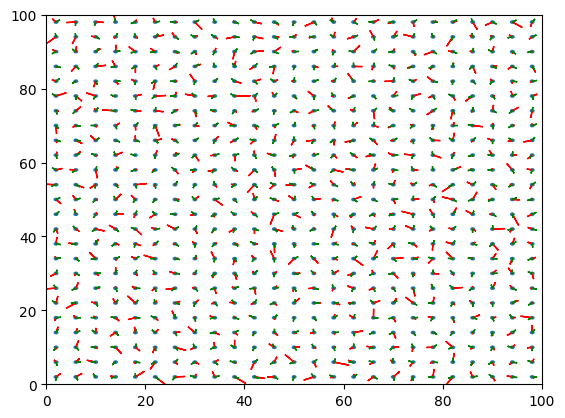

In [32]:
fig, ax = plt.subplots()
def update(frame):

# Function to update the animation
    ax.clear()
    ax.set_xlim(0, box_size)
    ax.set_ylim(0, box_size)

    # Plot the particles at the given frame as circles
    for x, y , vx, vy, phi, PE in particle_positions[frame]:
        circle = plt.Circle((x, y), radius=r, linewidth=0)
        ax.add_patch(circle)
        
    # Add an arrow to represent the direction of movement
        arrow = plt.Arrow(x, y, vx, vy, width=0.1, color='red')
        ax.add_patch(arrow)

    # Add an arrow to represent the direction of movement
        arrow = plt.Arrow(x, y, np.cos(phi), np.sin(phi), width=0.1, color='green')
        ax.add_patch(arrow)

# Create the animation
animation = FuncAnimation(fig, update, frames=len(particle_positions), interval=100)

# Save the animation as a GIF
# animation.save(path+'particle_animation.gif', writer='pillow')  # For GIF
# Save the animation as a video
animation.save(path+'particle_animation.mp4', writer='ffmpeg')  # For MP4


# Persistence and Fourier Transform of Persistence

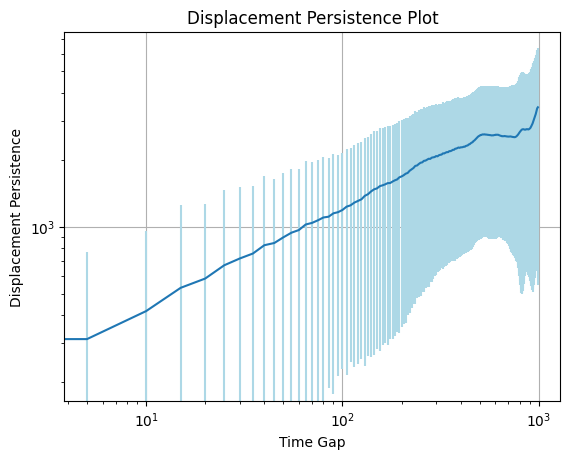

In [42]:
def displacement_persistence():

    # Create an empty list to store the persistence list of each particle at each gap to take average later
    persistencePerParticle = [[0.0] * int(math.floor(len(data) - 1.0)) for i in range(numParticles)]
    # Create a list which stores the average persistence of each particle at a given gap
    averagePersistencePerGap = [0.0] * math.floor(len(data) -1.0)
    # Create a list to store the standard deviation of persistence values at each gap
    stdPersistencePerGap = [0.0] * math.floor(len(data) -1.0)

    # Create a for loop running through each particle
    for i in range(numParticles):
        # Create an empty list to store the persistence values of each gap
        persistencePerGap = [0.0] * math.floor(len(data) -1.0)

        # Create a for loop running through half the size of the number of timesteps; here j will be called "gap"
        for j in range(math.floor(len(data) -1.0)):
            for k in range(len(data) - j - 1):
                # For each k calculate the squared displacement between the two points under consideration and add it to the list
                dx = float(data[k+j+1][i][0]) - float(data[k][i][0])
                dy = float(data[k+j+1][i][1]) - float(data[k][i][1])
                persistencePerGap[j] += dx*dx + dy*dy

            # Take the average of the list and store it in the list
            persistencePerGap[j] /= (len(data) - j - 1)

        # Add the list to the list of lists
        persistencePerParticle[i] = persistencePerGap


    # Create a for loop running through half the size of the number of timesteps; here j will be called "gap"
    for j in range(math.floor(len(data)-1.0)):
        # Create a list to store the persistence values of each particle at a given gap
        persistenceValues = []

        # Create a for loop running through each particle
        for i in range(numParticles):
            # Add the persistence of each particle at a given gap to the list
            persistenceValues.append(persistencePerParticle[i][j])

        # Calculate the mean and standard deviation of the persistence values
        meanPersistence = np.mean(persistenceValues)
        stdPersistence = np.std(persistenceValues)

        # Store the mean and standard deviation in the respective lists
        averagePersistencePerGap[j] = meanPersistence
        stdPersistencePerGap[j] = stdPersistence

    # Plot the log plot of displacement persistence using matplotlib with x axis as i*dataCompression*timestep and y axis as averagePersistencePerGap[i]
    plt.errorbar([i*dataCompression*timestep for i in range(math.floor(len(data)-1.0))], averagePersistencePerGap, yerr=stdPersistencePerGap, ecolor = 'lightblue', capsize=0)
    plt.yscale('log')
    plt.xscale('log')
    plt.grid()
    plt.xlabel("Time Gap")
    plt.ylabel("Displacement Persistence")
    plt.title("Displacement Persistence Plot")
    plt.savefig("displacement_persistence.png")


displacement_persistence()

c:\Users\alanb\AppData\Local\Programs\Python\Python312\Lib\site-packages\matplotlib\cbook.py:1699: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
c:\Users\alanb\AppData\Local\Programs\Python\Python312\Lib\site-packages\matplotlib\cbook.py:1345: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


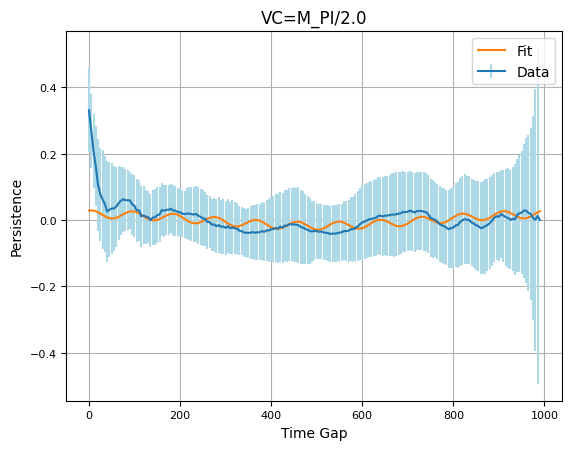

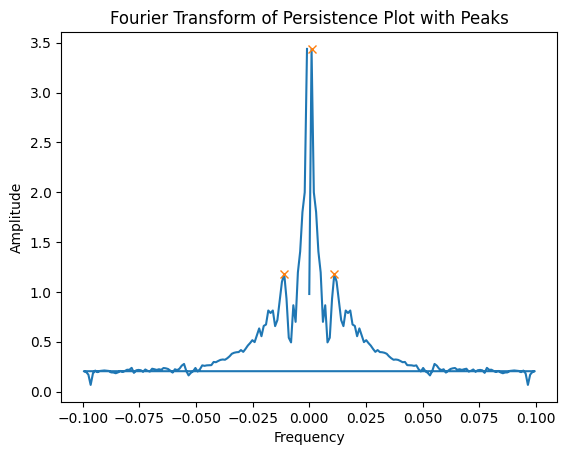

In [45]:
def persistenceFitV2():

    # Create an empty list to store the persistence list of each particle at each gap to take average later
    persistencePerParticle = [[0.0] * int(math.floor(len(data) - 1.0)) for i in range(numParticles)]
    averagePersistencePerGap = [0.0] * math.floor(len(data) -1.0)
    # Create a list to store the standard deviation of persistence values at each gap
    stdPersistencePerGap = [0.0] * math.floor(len(data) -1.0)

    # Create a for loop running through each particle
    for i in range(numParticles):
        # Create an empty list to store the persistence values of each gap
        persistencePerGap = [0.0] * math.floor(len(data) -1.0)

        # Create a for loop running through  the number of timesteps; here j will be called "gap"
        for j in range(math.floor(len(data) -2.0)):
            for k in range(len(data) - j - 2):
                # For each k calculate (cos(data[k][i][4])*cos(data[k+j+1][i][4]))/(cos(data[k][i][4]*cos(data[k][i][4]) and add it to the list
                # cos function is being called with an argument of type float which is a double in C++
                cos1=(data[k+1][i][0] - data[k][i][0]) / math.sqrt((data[k+1][i][0] - data[k][i][0]) ** 2 + (data[k+1][i][1] - data[k][i][1]) ** 2)
                cos2=(data[k+j+2][i][0] - data[k+j+1][i][0]) / math.sqrt((data[k+j+2][i][0] - data[k+j+1][i][0]) ** 2 + (data[k+j+2][i][1] - data[k+j+1][i][1]) ** 2)
                
                persistencePerGap[j] += cos1 * cos2 

            # Take the average of the list and store it in the list
            persistencePerGap[j] /= (len(data) - j - 2)
        persistencePerParticle[i] = persistencePerGap

    # Create a for loop running through half the size of the number of timesteps; here j will be called "gap"
    for j in range(math.floor(len(data)-1.0)):
        persistenceValues = []
        for i in range(numParticles):
            # Add the persistence of each particle at a given gap to the list
            persistenceValues.append(persistencePerParticle[i][j])

        # Calculate the mean and standard deviation of the persistence values
        meanPersistence = np.mean(persistenceValues)
        stdPersistence = np.std(persistenceValues)
        
        # Store the mean and standard deviation in the respective lists
        averagePersistencePerGap[j] = meanPersistence
        stdPersistencePerGap[j] = stdPersistence

    # Calculate the Fourier transform of the persistence data
    fft = np.fft.fft(averagePersistencePerGap)
    freq = np.fft.fftfreq(len(averagePersistencePerGap), d=(dataCompression*timestep))

    # Find the peaks in the Fourier transform
    peaks, properties = find_peaks(np.abs(fft), prominence=(0.2, None))
    # Create a new frequency spectrum with zeros everywhere
    new_fft = np.zeros_like(fft)
    # Set the values at the major peak indices to the original complex amplitudes
    new_fft[peaks] = fft[peaks]
    # Perform Inverse Fourier Transform
    reconstructed_signal = np.fft.ifft(new_fft)

    # Fit the averagePersistencePerGap data using the peak frequencies in the persistence plot
    # plt.plot([i*dataCompression*timestep for i in range(math.floor(len(data)-1.0))], averagePersistencePerGap, label='Data')
    plt.errorbar([i*dataCompression*timestep for i in range(math.floor(len(data)-1.0))], averagePersistencePerGap, yerr=stdPersistencePerGap, ecolor = 'lightblue', capsize=0, label='Data')
    plt.plot([i*dataCompression*timestep for i in range(math.floor(len(data)-1.0))], reconstructed_signal, label='Fit')
    plt.xticks(fontsize=8)
    plt.yticks(fontsize=8)
    plt.grid()
    plt.xlabel("Time Gap")
    plt.ylabel("Persistence")
    plt.title("VC=" + theta)
    plt.legend()
    plt.savefig(path+"persistence_Fit.png")
    
    #Plot the Fourier transform
    fig, ax = plt.subplots()
    ax.plot(freq, np.abs(fft))
    ax.plot(freq[peaks], np.abs(fft)[peaks], "x")
    ax.set_xlabel('Frequency')
    ax.set_ylabel('Amplitude')
    ax.set_title('Fourier Transform of Persistence Plot with Peaks')
    plt.savefig(path+"persistence_fft.png")
    

persistenceFitV2()

[0.26351199 0.07540702 0.5311995 ]


C:\Users\alanb\AppData\Local\Temp\ipykernel_98804\3761047600.py:49: RuntimeWarning: overflow encountered in exp
  return a * np.exp(-b * np.array(v)) + c


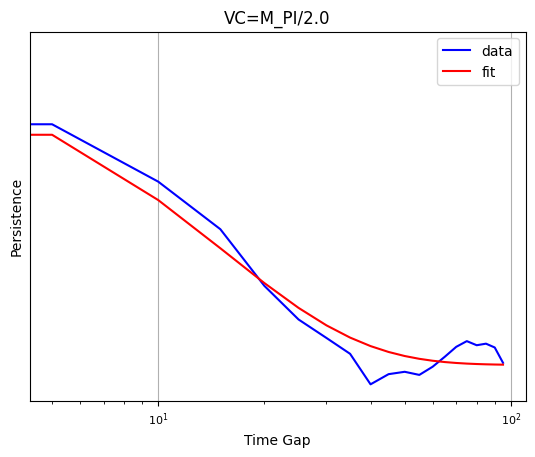

In [46]:
def persistenceFitV3():

    # Create an empty list to store the persistence list of each particle at each gap to take average later
    persistencePerParticle = [[0.0] * int(math.floor(len(data) - 1.0)) for i in range(numParticles)]
    averagePersistencePerGap = [0.0] * math.floor(len(data) -1.0)
    # Create a list to store the standard deviation of persistence values at each gap
    stdPersistencePerGap = [0.0] * math.floor(len(data) -1.0)

    # Create a for loop running through each particle
    for i in range(numParticles):
        # Create an empty list to store the persistence values of each gap
        persistencePerGap = [0.0] * math.floor(len(data) -1.0)

        # Create a for loop running through half the size of the number of timesteps; here j will be called "gap"
        for j in range(math.floor(len(data) -1.0)):
            for k in range(len(data) - j - 2):
                # For each k calculate (cos(data[k][i][4])*cos(data[k+j+1][i][4]))/(cos(data[k][i][4]*cos(data[k][i][4]) and add it to the list
                # cos function is being called with an argument of type float which is a double in C++
                cos1=(data[k+1][i][0] - data[k][i][0]) / math.sqrt((data[k+1][i][0] - data[k][i][0]) ** 2 + (data[k+1][i][1] - data[k][i][1]) ** 2)
                cos2=(data[k+j+2][i][0] - data[k+j+1][i][0]) / math.sqrt((data[k+j+2][i][0] - data[k+j+1][i][0]) ** 2 + (data[k+j+2][i][1] - data[k+j+1][i][1]) ** 2)
                if cos1 * cos2>=0:
                #if (cos1>0) & (cos2>0):
                    persistencePerGap[j] += 1.0

            # Take the average of the list and store it in the list
            persistencePerGap[j] /= int(len(data) - j - 1)
        persistencePerParticle[i] = persistencePerGap

    # Create a for loop running through persistencePerParticle[i] and finding the mean
    for j in range(math.floor(len(data)-1.0)):
        persistenceValues = []
        for i in range(numParticles):
            # Add the persistence of each particle at a given gap to the list
            persistenceValues.append(persistencePerParticle[i][j])

        # Calculate the mean and standard deviation of the persistence values
        meanPersistence = np.mean(persistenceValues)
        stdPersistence = np.std(persistenceValues)
        
        # Store the mean and standard deviation in the respective lists
        averagePersistencePerGap[j] = meanPersistence
        stdPersistencePerGap[j] = stdPersistence

    x = [i*dataCompression*timestep for i in range(math.floor(len(data)/10.0))]
    # y = [math.log(j, 2) for j in averagePersistencePerGap[:len(x)]]
    y = averagePersistencePerGap[:len(x)]
    #fit and plot the data with an exponential function and print the fit values
    def func(v, a, b, c):
        return a * np.exp(-b * np.array(v)) + c
    
    popt, pcov = curve_fit(func, x, y)
    print(popt)
    plt.plot(x, y, 'b-', label='data')
    plt.plot(x, func(x, *popt), 'r-', label='fit')
    

    plt.xticks(fontsize=8)
    plt.yticks(fontsize=8)
    plt.yscale('log', base=2)
    plt.xscale('log')
    plt.grid()
    plt.xlabel("Time Gap")
    plt.ylabel("Persistence")
    plt.title("VC=" + theta)
    plt.legend()
    plt.savefig("persistence_Fit.png")
persistenceFitV3()

[0.49705461 0.18586917 0.49664059]


C:\Users\alanb\AppData\Local\Temp\ipykernel_9164\2280830679.py:25: RuntimeWarning: overflow encountered in exp
  return a * np.exp(-b * np.array(v)) + c


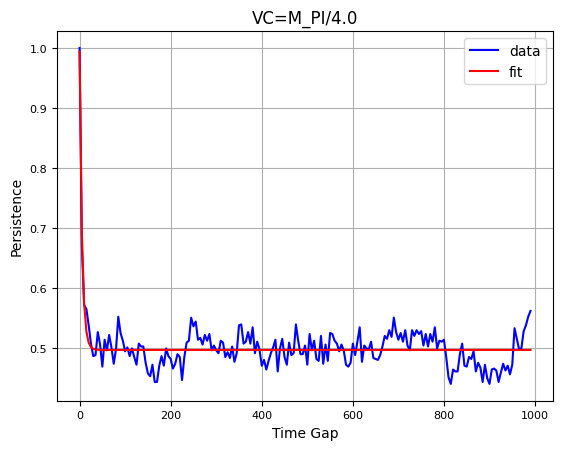

In [72]:
def persistenceFitV5():

    # Create an empty list to store the persistence values of each gap
    persistencePerGap = [0.0] * math.floor(len(data) -1.0)

    # Create a for loop running through each particle
    for i in range(numParticles):

        # Create a for loop running through half the size of the number of timesteps; here j will be called "gap"
        for j in range(math.floor(len(data) -1.0)):
            cos1=(data[1][i][0] - data[0][i][0]) / math.sqrt((data[1][i][0] - data[0][i][0]) ** 2 + (data[1][i][1] - data[0][i][1]) ** 2)
            cos2=(data[j+1][i][0] - data[j][i][0]) / math.sqrt((data[j+1][i][0] - data[j][i][0]) ** 2 + (data[j+1][i][1] - data[j][i][1]) ** 2)
            if cos1 * cos2>=0:
                persistencePerGap[j] += 1.0

    # Create a for loop running through persistencePerParticle[i] and finding the mean
    for j in range(math.floor(len(data)-1.0)):
        persistencePerGap[j] /= numParticles

    x = [i*dataCompression*timestep for i in range(math.floor(len(data)-1.0))]
    # y = [math.log(j, 2) for j in averagePersistencePerGap[:len(x)]]
    y = persistencePerGap[:len(x)]
    #fit and plot the data with an exponential function and print the fit values
    def func(v, a, b, c):
        return a * np.exp(-b * np.array(v)) + c
    
    popt, pcov = curve_fit(func, x, y)
    print(popt)
    plt.plot(x, y, 'b-', label='data')
    plt.plot(x, func(x, *popt), 'r-', label='fit')
    

    plt.xticks(fontsize=8)
    plt.yticks(fontsize=8)
    #scale y axis to log with base 2
    # plt.yscale('log', base=2)
    # plt.xscale('log')
    plt.grid()
    plt.xlabel("Time Gap")
    plt.ylabel("Persistence")
    plt.title("VC=" + theta)
    plt.legend()
    plt.savefig("persistence_Fit5.png")
persistenceFitV5()